# Portfoliotheorie after Markowitz

## I. Getting the Data

### 1. Libraries

In [1]:
%matplotlib inline
import cvxopt as opt
from cvxopt import blas, solvers
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)
solvers.options['show_progress'] = False

### 2. Using the QUANDL-API to fetch the data

In [2]:
quandl.ApiConfig.api_key = '#############'
selected = [ 'CCE', 'MSFT', 'BLK', 'TSLA']

data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2013-09-02', 'lte': '2018-09-02' }, 
                        paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2018-03-27,TSLA,279.18
1,2018-03-26,TSLA,304.18
2,2018-03-23,TSLA,301.54
3,2018-03-22,TSLA,309.10
4,2018-03-21,TSLA,316.53


### 3. Preprocessing the data

In [3]:
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

# daily and annual returns
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

# yearly covariance
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

table.head()

adj_close                               
ticker             BLK        CCE       MSFT     TSLA
date                                                 
2013-09-03  239.114454  34.831922  28.550595  168.940
2013-09-04  241.217515  35.193436  27.937133  170.622
2013-09-05  238.198897  34.911816  27.972956  169.930
2013-09-06  236.802899  35.257028  27.898624  166.970
2013-09-09  238.452715  35.947451  28.349093  160.700

### 4. Export the data

In [4]:
table.to_csv('markowitz.csv',sep='\t', encoding='utf-8')

### 5. Visualizing share price development

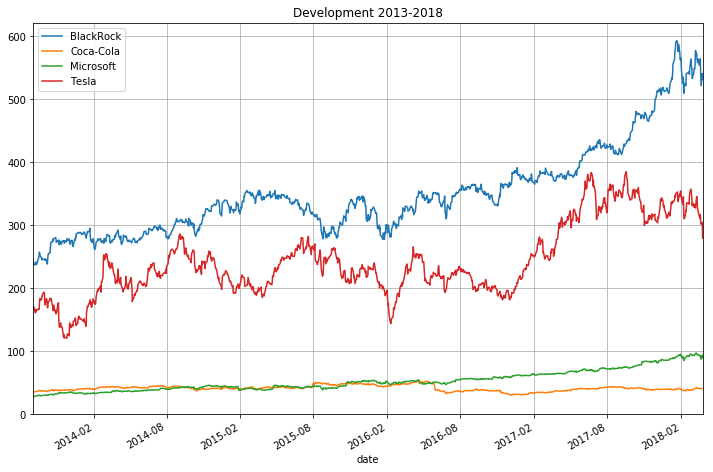

In [4]:
kurse = {'BlackRock': table['adj_close']['BLK'], 
         'Coca-Cola': table['adj_close']['CCE'], 
         'Microsoft': table['adj_close']['MSFT'], 
         'Tesla': table['adj_close']['TSLA']}
Aktienkurse = pd.DataFrame(kurse)

Aktienkurse.plot(title= 'Development 2013-2018', 
                 figsize=(12,8), grid=True, )


## II. Using sample data to demonstrate Markowitz Portfolio theory

### 1. Geneate portfolios

In [6]:
port_returns = []
port_volatility = []
stock_weights = []

num_assets = len(selected)
num_portfolios = 50000

for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

portfolio = {'Rendite': port_returns,
             'Volatilität': port_volatility}

for counter,symbol in enumerate(selected):
    portfolio[symbol+' Gewichtung'] = [weight[counter] \
                                       for weight in stock_weights]

df = pd.DataFrame(portfolio)
column_order = ['Rendite', 'Volatilität'] + \
[stock+' Gewichtung' for stock in selected]

df = df[column_order]


df.to_csv('markowitz.csv',sep='\t', encoding='utf-8')

df.head()

,Rendite,Volatilität,CCE Gewichtung,MSFT Gewichtung,BLK Gewichtung,TSLA Gewichtung
0,0.185679,0.203205,0.395547,0.162508,0.128836,0.313109
1,0.203940,0.189547,0.256206,0.150670,0.349254,0.243871
2,0.184239,0.214939,0.247231,0.201574,0.176416,0.374779
3,0.211883,0.241717,0.268356,0.036516,0.243558,0.451569
4,0.209904,0.219479,0.128396,0.123443,0.373984,0.374178


### 2. Export weighted portfolios

In [7]:
df.to_csv('Portfolios.csv',sep='\t', encoding='utf-8')

### 3. Darstellung der generierten Beispielportfolios

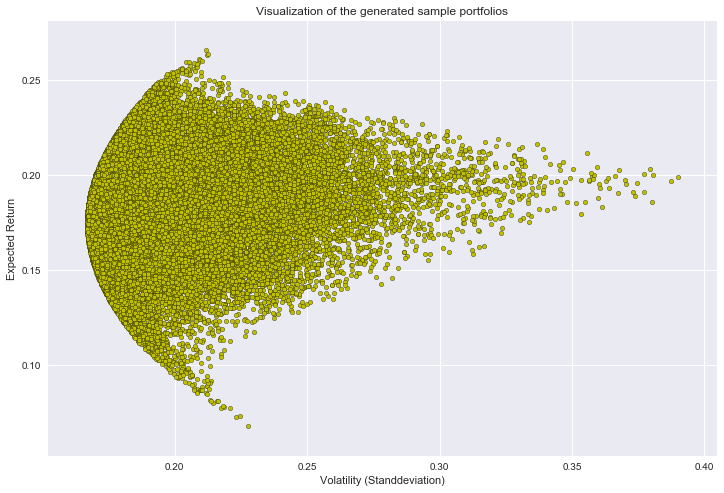

In [8]:
plt.style.use('seaborn')
df.plot.scatter(x='Volatilität', y='Rendite', color='y', edgecolors='black',
                figsize=(12, 8), grid=True)
plt.xlabel('Volatility (Standdeviation)')
plt.ylabel('Expected Return')
plt.title('Visualizing the generated sample portfolios')
plt.show()

### 4. Efficiency Frontier

In [10]:
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

num_assets = len(selected)
num_portfolios = 50000
rf_rate = 0.05

np.random.seed(101)

for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = (returns - rf_rate) / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

portfolio = {'Rendite': port_returns,
             'Volatilität': port_volatility,
             'Sharpe-Quotient': sharpe_ratio}

for counter,symbol in enumerate(selected):
    portfolio[symbol+' Gewichtung'] = [Weight[counter] \
                                       for Weight in stock_weights]

df = pd.DataFrame(portfolio)
column_order = ['Rendite', 'Volatilität', 'Sharpe-Quotient'] + \
[stock+' Gewichtung' for stock in selected]
df = df[column_order]

### 5. Sharpe-Quotient

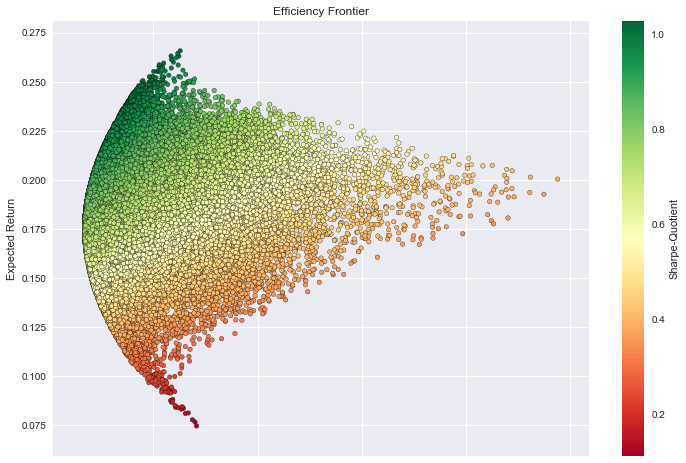

In [11]:
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatilität', y='Rendite', c='Sharpe-Quotient',
                cmap='RdYlGn', edgecolors='black', figsize=(12, 8), grid=True)
plt.xlabel('Volatility (Standarddeviation)')
plt.ylabel('Expected Return')
plt.title('Efficiency Frontier')
plt.show()

## III. Optimal Portfolios

### 1. Defining optimal portfolios

In [13]:
min_volatility = df['Volatilität'].min()
max_sharpe = df['Sharpe-Quotient'].max()

sharpe_portfolio = df.loc[df['Sharpe-Quotient'] == max_sharpe]
min_variance_port = df.loc[df['Volatilität'] == min_volatility]


### 2. Visualizing the optimal portfolios

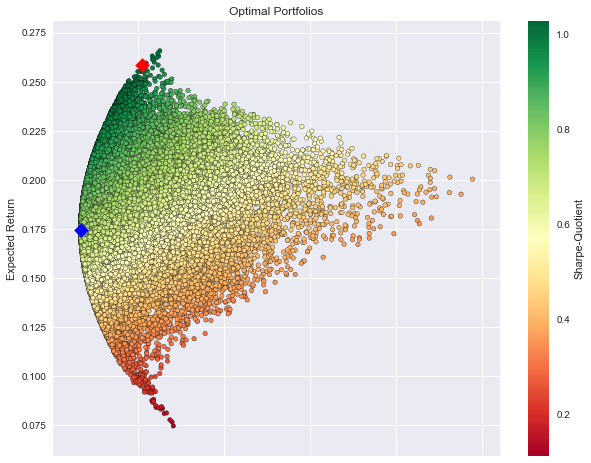

In [14]:
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatilität', y='Rendite', c='Sharpe-Quotient',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatilität'], y=sharpe_portfolio['Rendite'], 
            c='red', marker='D', s=100)
plt.scatter(x=min_variance_port['Volatilität'], y=min_variance_port['Rendite'], 
            c='blue', marker='D', s=100 )
plt.xlabel('Volatility (Standarddeviation)')
plt.ylabel('Expected Return')
plt.title('Optimal Portfolios')
plt.show()

### 3. Figures for the optimal portfolios

In [15]:
print('LEAST RISK PORTFOLIO')
print(' ')
print(min_variance_port.T)
print(' ')
print(' ')
print('PORTFOLIO WITH THE BEST RISK-RETURN-BALANCE')
print(sharpe_portfolio.T)


LEAST RISK PORTFOLIO
 
                     6445
Rendite          0.174301
Volatilität      0.166894
Sharpe-Quotient  0.744787
CCE Gewichtung   0.308855
MSFT Gewichtung  0.341072
BLK Gewichtung   0.305602
TSLA Gewichtung  0.044471
 
 
PORTFOLIO WITH THE BEST RISK-RETURN-BALANCE
                    24350
Rendite          0.258650
Volatilität      0.202789
Sharpe-Quotient  1.028902
CCE Gewichtung   0.166976
MSFT Gewichtung  0.002247
BLK Gewichtung   0.811257
TSLA Gewichtung  0.019520
